## Implementation of class $LeastSquareLine$

In [1]:
!pip3 install scikit-image==0.14.2 && pip3 install numpy==1.15

    100% |████████████████████████████████| 25.3MB 33kB/s  eta 0:00:01   26% |████████▌                       | 6.7MB 47.8MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/19/5e/23dcc0ce3cc2abe92efd3cd61d764bee6ccdf1b667a1fb566f45dc249953/Pillow-7.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/59/bb/d2b85265ec9fa3c1922210c9393d4cdf7075cc87cce6fe671d7455f80fbc/PyWavelets-1.1.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/41/8f/dd6a8e85946def36e4f2c69c84219af0fa5e832b018c970e92f2ad337e45/networkx-2.4-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4e/11/06958a2b895a3853206dea1fb2a5b11bf044f626f90745987612af9c8f2c/matplotlib-3.1.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.p

In [3]:
%matplotlib notebook

from skimage.measure import ransac
import numpy as np
import numpy.linalg as la
import matplotlib
import matplotlib.pyplot as plt

#### Function $estimate$ should update line parameters $a$ and $b$ correpsonding to line model $y=ax+b$. Here I use pseudo inverse of matrix $A$ for the linear regression model.

In [12]:
class LeastSquareLine:

    def __init__(self):
        self.a = 0.0
        self.b = 0.0
        
    def estimate(self, points2D):
        B = points2D[:,1]
        A = np.copy(points2D)
        A[:,1] = 1.0 

        # Vector B and matrix A are already defined. Change code below
        coefficient = (la.inv(A.T @ A) @ A.T @ B).flatten()
        self.a = coefficient[0]
        self.b = coefficient[1]
        return True
        
    def predict(self, x): return (self.a * x) + self.b
    
    def predict_y(self, x): return (self.a * x) + self.b
            
    def residuals(self, points2D):
        return points2D[:,1] - self.predict(points2D[:,0])
    
    def line_par(self):
        return self.a, self.b

#### The code below generates a noisy cloud of points in ${\cal R}^2$ from a given line (ground truth) and a group of outliers.

<IPython.core.display.Javascript object>


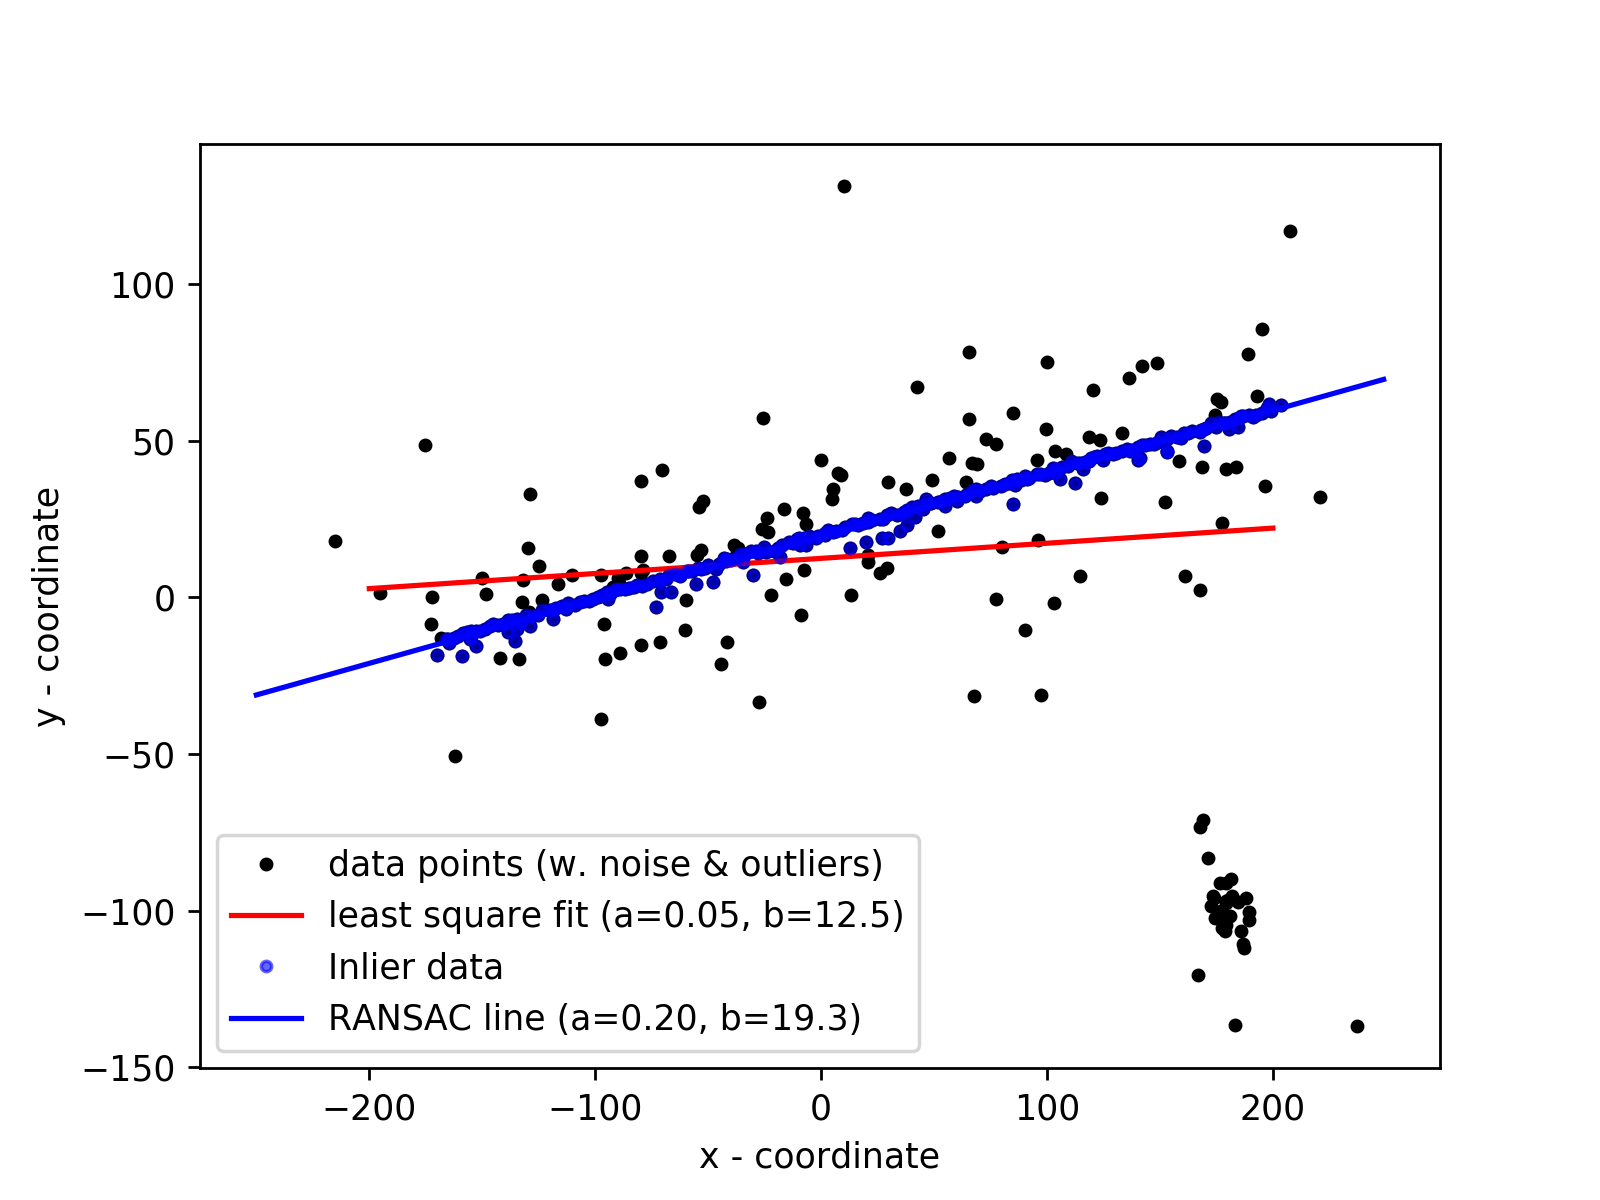

In [13]:
np.random.seed(seed=1)

# parameters for "true" line y = a*x + b
a, b = 0.2, 20.0

# x-range of points [x1,x2]
x_start, x_end = -200.0, 200.0

# generate the "true" line points
x = np.arange(x_start,x_end)
y = a * x + b               
data = np.column_stack([x, y])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data[:faulty.shape[0]] = faulty   # replacing the first 30 points in data with faulty (outliers)

# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data += 0.5 * noise
data[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Code below uses $LeastSquareLine$ for least-square line fitting for the data above. The estimated line (red line) is displayed in the same figure above. Of course, the estimated least-square line is highly skewed by the outliers.

In [14]:
LSline = LeastSquareLine()
print(LSline.estimate(data))
a_ls, b_ls = LSline.line_par()

# visualizing estimated line
ends = np.array([x_start,x_end])
ax.plot(ends, LSline.predict(ends), '-r', label='least square fit (a={:4.2f}, b={:4.1f})'.format(a_ls,b_ls))
ax.legend(loc='lower left')
plt.show()

True


## RANSAC for robust single line fitting

#### Derivation of the least number of times which RANSAC should sample a random pair of points from the set to achieve probability $p\geq 0.95$ that in at least one of the sampled pairs has both inliers. Suppose the number of inliers and outliers are denoted by $N_i$ and $N_o$. 

$Derivation$:

The least number of times to sample at least one random pair of inliers with probability $p\geq 0.95$ is equivalent to the most number of times to sample random pairs that always include at least one outlier with probability $p> 0.05$ plus one.

At each round, the probability to sample a random pair of inliers (sampling without replacement)

$$p_{bothInliers}=\frac{N_i \choose 2}{N_i+N_o \choose 2}=\frac{N_i(N_i-1)}{(N_i+N_o)(N_i+N_o-1)}$$
$$p_{\neg bothInliers}=1-p_{bothInliers}=\frac{N_o^2+2N_iN_o-N_o}{(N_i+N_o)(N_i+N_o-1)}$$

$$p_{\neg bothInliers}^{k-1} > 0.05,k\in\mathbb{Z}^+$$

$$k < \frac{\ln(0.05)}{\ln(p_{\neg bothInliers})}+1$$


#### Estimation of the minimum number of sampled pairs needed to get RANSAC to "succeed" (to get at least one pair of inliers) with $p\geq 0.95$. Then, this number can be used as a value of the parameter $max\text{_}trials$  inside function $ransac$. The result (blue line) is displayed in the same figure above.

$Numerical\:Solution$:

Assume both faulty points and data points whose noise level $\sigma=20$ are classified as outliers.

$$N_i=\frac{3}{4}(400-30)=277, N_o=400-277=123$$

$$p_{\neg bothInliers}=0.52$$

$$k < \frac{\ln(0.05)}{\ln(0.52)}+1$$

$$k < 5.58, k=5$$

In [15]:
# robustly fit line using RANSAC algorithm
model_robust, inliers = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=5)
a_rs, b_rs = model_robust.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust = model_robust.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers, 0], data[inliers, 1], '.b', alpha=0.6, label='Inlier data')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line (a={:4.2f}, b={:4.1f})'.format(a_rs,b_rs))
ax.legend(loc='lower left')
plt.show()

## Sequential RANSAC for robust multi-line fitting

#### Generating noisy data with outliers

<IPython.core.display.Javascript object>


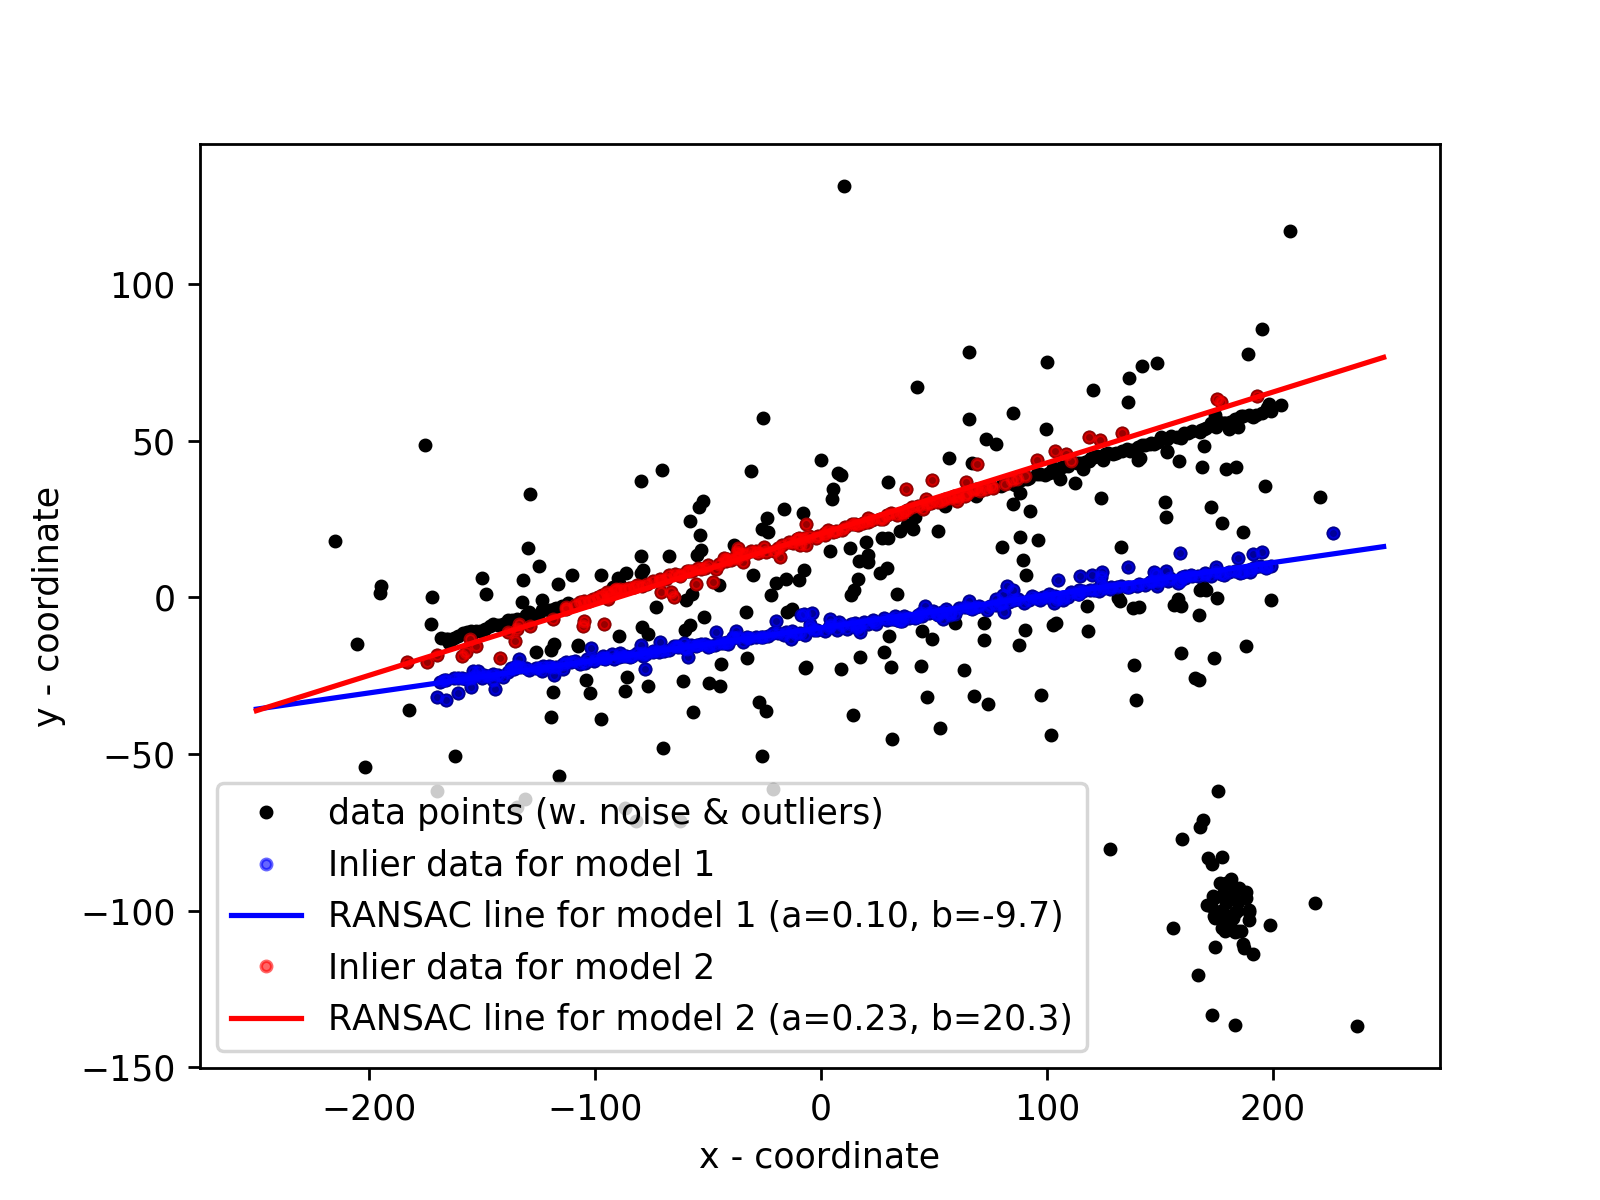

In [16]:
# parameters for "true" lines y = a*x + b
a2, b2 = 0.1, -10.0

# generate the "true" line points
y2 = a2 * x + b2
data2 = np.column_stack([x, y2])    # staking data points into (Nx2) array

# add faulty data (i.e. outliers)
faulty = np.array(30 * [(180., -100)])  # (30x2) array containing 30 rows [180,-100]  (points)
faulty += 5 * np.random.normal(size=faulty.shape)  # adding Gaussian noise to these points
data2[:faulty.shape[0]] = faulty   # replacing the first 30 points in data2 with faulty (outliers)


# add gaussian noise to coordinates
noise = np.random.normal(size=data.shape) # generating Gaussian noise (variance 1) for each data point (rows in 'data')
data2+= 0.5 * noise
data2[::2] += 5 * noise[::2]  # every second point adds noise with variance 5
data2[::4] += 20 * noise[::4] # every fourth point adds noise with variance 20

data = np.concatenate((data,data2)) # combining with previous data

fig, ax = plt.subplots()
ax.plot(data[:,0], data[:,1], '.k', label='data points (w. noise & outliers)')
ax.set_xlabel('x - coordinate')
ax.set_ylabel('y - coordinate')
ax.legend(loc='lower left')
plt.show()

#### Numerical estimation of maximum trials for sequential RANSAC 

Estimates:

Assume both faulty points and data points whose noise level $\sigma=20$ are classified as outliers.

In the first round, we have 800 data points in total. 

$$N_i=\frac{3}{4}(400-30)=277. N_o = 800-N_i=523$$

$$p_{\neg bothInliers}=0.88$$

$$k < \frac{\ln(0.05)}{\ln(0.88)}+1$$

$$k < 24.43, k=24$$

Assume we found 277 inliers in the first round, in the second round, we have 523 data points in total.

$$N_i=\frac{3}{4}(400-30)=277. N_o = 523-N_i=246$$

$$p_{\neg bothInliers}=0.72$$

$$k < \frac{\ln(0.05)}{\ln(0.72)}+1$$

$$k < 10.12, k=10$$


In [17]:
# robustly fit line using RANSAC algorithm
model_robust_1, inliers_1 = ransac(data, LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=24)
a_rs_1, b_rs_1 = model_robust_1.line_par()

remaining_data = data[~inliers_1]
model_robust_2, inliers_2 = ransac(remaining_data, LeastSquareLine, min_samples=2, residual_threshold=5, max_trials=10)
a_rs_2, b_rs_2 = model_robust_2.line_par()

# generate coordinates of estimated models
line_x = np.arange(-250, 250)
line_y_robust_1 = model_robust_1.predict_y(line_x)
line_y_robust_2 = model_robust_2.predict_y(line_x)

#fig, ax = plt.subplots()
ax.plot(data[inliers_1, 0], data[inliers_1, 1], '.b', alpha=0.6, label='Inlier data for model 1')
ax.plot(line_x, line_y_robust_1, '-b', label='RANSAC line for model 1 (a={:4.2f}, b={:4.1f})'.format(a_rs_1,b_rs_1))

ax.plot(remaining_data[inliers_2, 0], remaining_data[inliers_2, 1], '.r', alpha=0.6, label='Inlier data for model 2')
ax.plot(line_x, line_y_robust_2, '-r', label='RANSAC line for model 2 (a={:4.2f}, b={:4.1f})'.format(a_rs_2,b_rs_2))

ax.legend(loc='lower left')
plt.show()